# Convolutional Layer

In this notebook, we visualize four filtered outputs (a.k.a. activation maps) of a convolutional layer. 

In this example, *we* are defining four filters that are applied to an input image by initializing the **weights** of a convolutional layer, but a trained CNN will learn the values of these weights.

<img src='notebook_ims/conv_layer.gif' height=60% width=60% />

### Import the image

In [4]:
#!pip install opencv-python

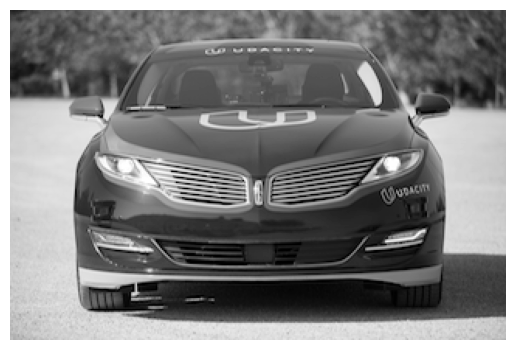

In [5]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# TODO: Feel free to try out your own images here by changing img_path
# to a file path to another image on your computer!
img_path = 'data/udacity_sdc.png'

# load color image 
bgr_img = cv2.imread(img_path)
# convert to grayscale
gray_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)

# normalize, rescale entries to lie in [0,1]
gray_img = gray_img.astype("float32")/255

# plot image
plt.imshow(gray_img, cmap='gray')
plt.axis("off")
plt.show()

### Define and visualize the filters

In [6]:
import numpy as np

## TODO: Feel free to modify the numbers here, to try out another filter!
filter_vals = np.array([[-1, -1, 1, 1], [-1, -1, 1, 1], [-1, -1, 1, 1], [-1, -1, 1, 1]])

print('Filter shape: ', filter_vals.shape)


Filter shape:  (4, 4)


In [7]:
filter_vals

array([[-1, -1,  1,  1],
       [-1, -1,  1,  1],
       [-1, -1,  1,  1],
       [-1, -1,  1,  1]])

In [8]:
filter_vals.T

array([[-1, -1, -1, -1],
       [-1, -1, -1, -1],
       [ 1,  1,  1,  1],
       [ 1,  1,  1,  1]])

In [9]:
# Defining four different filters, 
# all of which are linear combinations of the `filter_vals` defined above

# define four filters
filter_1 = filter_vals
filter_2 = -filter_1
filter_3 = filter_1.T
filter_4 = -filter_3
# Stack them together in a (4, 4, 4) array
filters = np.array([filter_1, filter_2, filter_3, filter_4])

# For an example, print out the values of filter 1
print('Filter 1: \n', filter_1)

Filter 1: 
 [[-1 -1  1  1]
 [-1 -1  1  1]
 [-1 -1  1  1]
 [-1 -1  1  1]]


In [10]:
filters

array([[[-1, -1,  1,  1],
        [-1, -1,  1,  1],
        [-1, -1,  1,  1],
        [-1, -1,  1,  1]],

       [[ 1,  1, -1, -1],
        [ 1,  1, -1, -1],
        [ 1,  1, -1, -1],
        [ 1,  1, -1, -1]],

       [[-1, -1, -1, -1],
        [-1, -1, -1, -1],
        [ 1,  1,  1,  1],
        [ 1,  1,  1,  1]],

       [[ 1,  1,  1,  1],
        [ 1,  1,  1,  1],
        [-1, -1, -1, -1],
        [-1, -1, -1, -1]]])

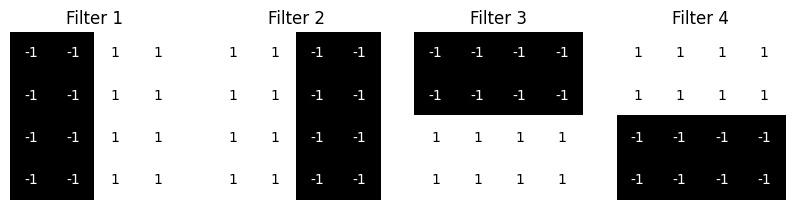

In [11]:
# visualize all four filters
from helpers import visualize_filters

visualize_filters(filters)

## Define a convolutional layer 

The various layers that make up any neural network are documented, [here](http://pytorch.org/docs/stable/nn.html). For a convolutional neural network, we'll start by defining a __Convolutional layer__.

Initialize a single convolutional layer so that it contains all your created filters:

In [12]:
import torch

# defines the convolutional layer, assumes there are 4 grayscale 
# filters
k_height = filters.shape[-1]
k_width = k_height
conv_layer = torch.nn.Conv2d(
    # Number of input channels. This is grayscale, so 1.
    # If the image was a normal RGB image, this would be 3.
    in_channels=1,
    # Number of output feature maps. Let's do 4 like the filters
    # we want to use (remember, each filter results in one 
    # feature map)
    out_channels=4, 
    # Size of the convolutional kernel
    kernel_size=(k_height, k_width), 
    stride=1, 
    padding=0,
    # Let's skip the bias for the moment, so we can easily
    # initialize our layer with the filters we already have
    bias=False,
)

# NOTE: the next step is only useful for this tutorial. When using 
# conv layers in a model you will not initialize the weights in 
# this way
# Ok, so let's initialize the weights of the layer we just
# created with the filters we already have
# so we will be able to see how pytorch applies filters and
# what are their products
# Transforms the filters to pytorch Tensors
weights = (torch
           .from_numpy(filters)  # note: this does not copy the data
           # add the n_channels dimension, so the tensor has the 
           # shape 
           # (n_filters, n_channels, filter_height, filter_width)
           .unsqueeze(dim=1)
           # Make sure we have a FloatTensor (fp32)
           .type(torch.FloatTensor)
          )
# Assign the filters to the weights of the layer
# NOTE: we use torch.nn.Parameter so the weights
# are recognized as parameters of the model
conv_layer.weight = torch.nn.Parameter(weights)

And now let's see it in action on our input image:

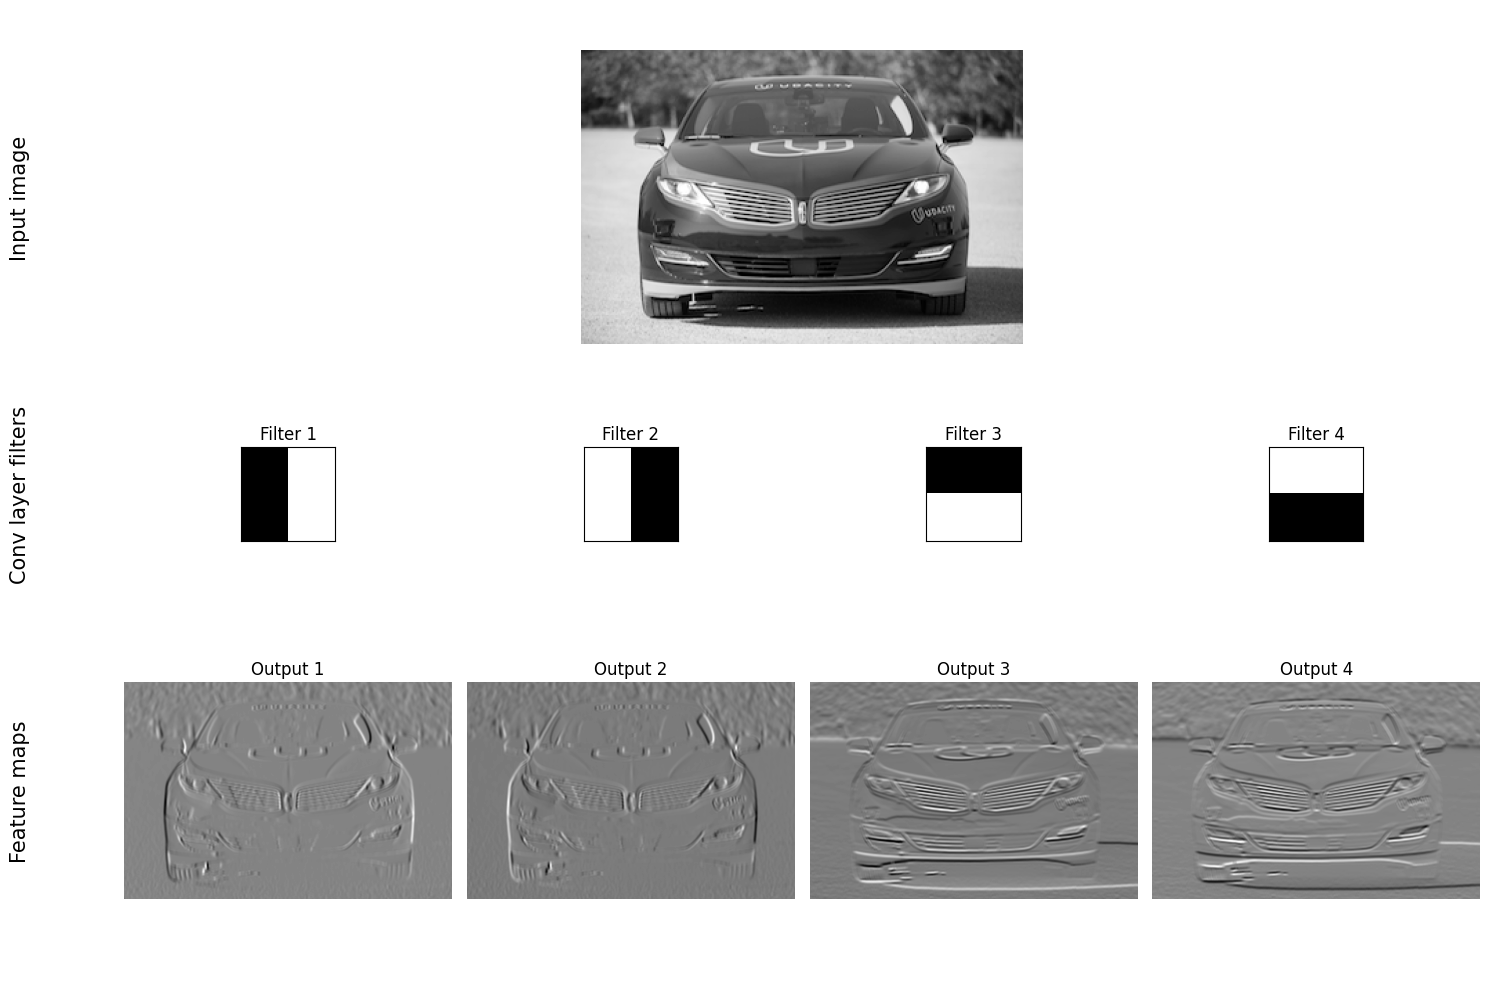

In [13]:
from helpers import show_feature_maps

# convert the image into an input Tensor
# with shape (n_items_in_batch, n_channels, height, width)
x = (
    torch.from_numpy(gray_img)
    # Add one dimension for batch
    .unsqueeze(0)
    # Add dimension for n_channels
    .unsqueeze(1)
)

# Pass the image through the layer
# (this calls the .forward of the layer)
feature_maps = conv_layer(x)

show_feature_maps(gray_img, feature_maps, filters)

#### A PyTorch model: `__init__` and `forward`
Let's now see how we can use a convolutional layer (or any other layer) in a model in PyTorch.

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the forward behavior of a network that applyies those initialized layers to an input (`x`) in the function `forward` (named after "forward pass", as opposed to backpropagation). In PyTorch we convert all inputs into the Tensor datatype, which is similar to a list data type in Python. 

Below, I define the structure of a class called `Net` that has a convolutional layer similar to what we used before:

In [14]:
# define a neural network with a single convolutional layer with four filters
class Net(torch.nn.Module):
    
    # NOTE: we can add whatever parameters we want to the constructor. In this
    # case, we add as a parameter the array of the filters
    def __init__(self, filters):
        
        super(Net, self).__init__()
        
        # defines the convolutional layer
        k_height = filters.shape[-1]
        k_width = k_height
        
        self.conv_layer = torch.nn.Conv2d(
            in_channels=1,
            out_channels=4, 
            kernel_size=(k_height, k_width), 
            stride=1, 
            padding=0,
            bias=False
        )
        
        # Let's also add an activation function, 
        # for example a Rectified Linear Unit
        self.relu = torch.nn.ReLU()
        
        # The following part is not usually part of a pytorch model
        # (because the weights are learned). Here we initialize them
        # to the filters we manually defined just like we did before
        weights = (torch
                   .from_numpy(filters)
                   .unsqueeze(dim=1)
                   .type(torch.FloatTensor)
                  )
        self.conv_layer.weight = torch.nn.Parameter(weights)
        

    def forward(self, x):
        # apply convolutional layer
        x = self.conv_layer(x)
        
        # apply activation
        x = self.relu(x)
        
        return x
    
# instantiate the model and set the weights
model = Net(filters)

# print out the layer in the network
# REMEMBER: the output of the following print is NOT necessarily the structure
# of the network. Indeed, things will be printed here in the order
# that they are defined in the __init__, and NOT in the order they
# are used in the .forward method. Try to switch the definition of
# self.relu and self.conv_layer in the __init__ (without changing the 
# .forward method) and see what happens to this print
print(model)

Net(
  (conv_layer): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (relu): ReLU()
)


#### ReLU activation
Remember that the activation function called ReLU (Rectified Linear Unit) turns all negative pixel values in 0's (black) while keeping the positive values untouched:

<img src='notebook_ims/relu_ex.png' height=50% width=50% />

Let's visualize what happens when applying it to our feature maps (compare it with the feature maps we have obtained before):

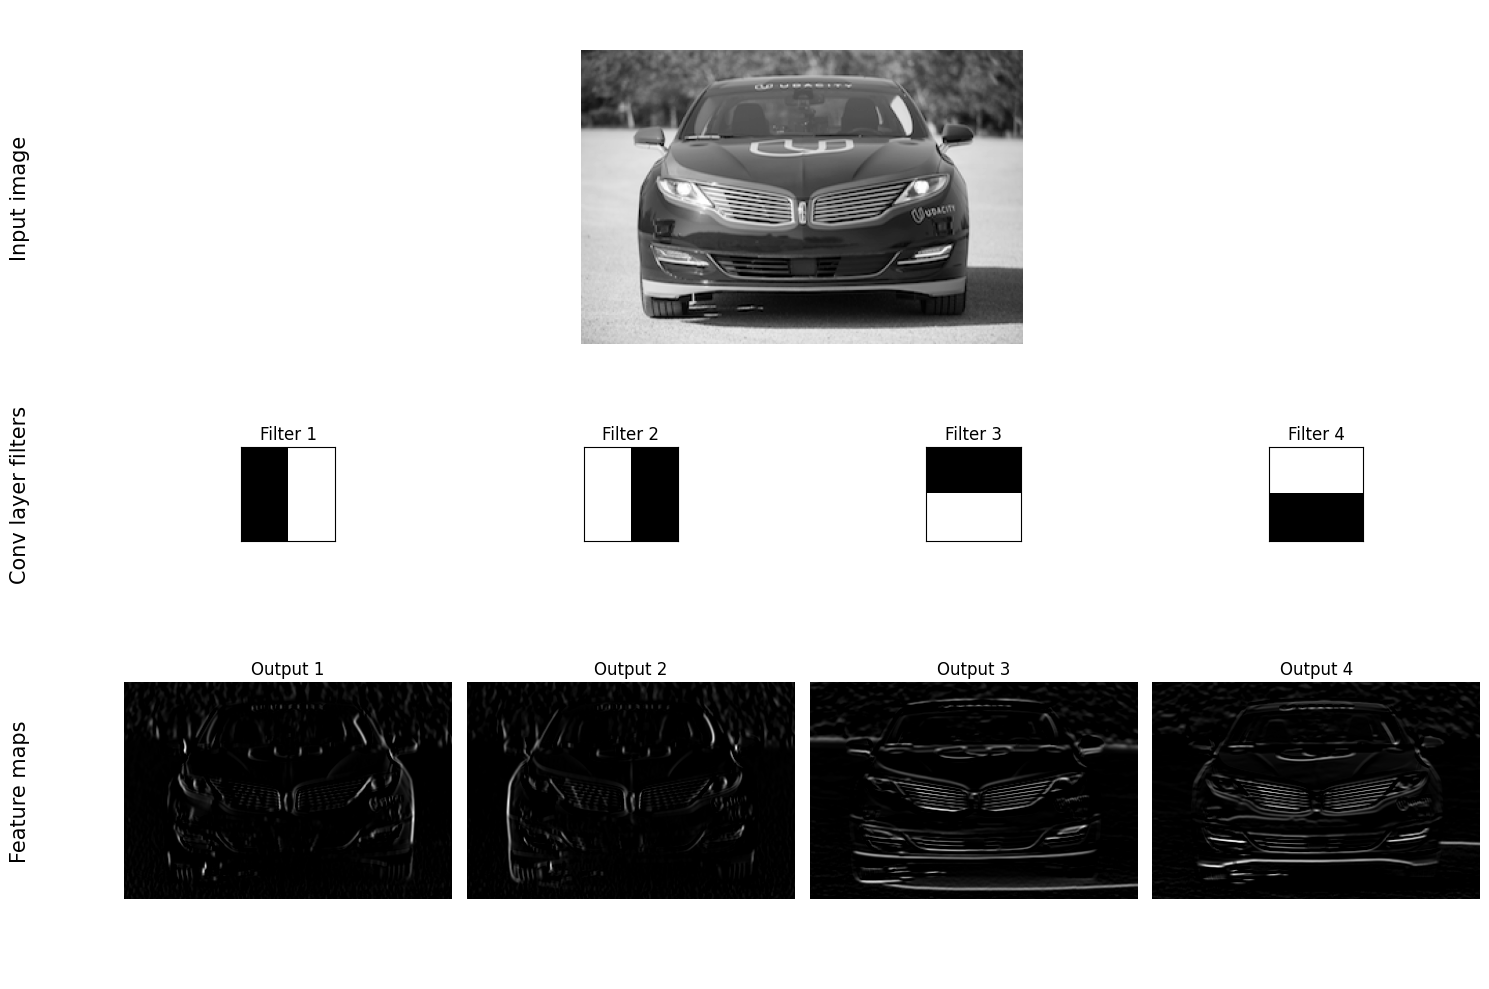

In [15]:
post_act_feature_maps = model(x)
show_feature_maps(gray_img, post_act_feature_maps, filters)

Compare these feature maps with what we obtained from the conv layer without activation. We can immediately see that applying ReLU is equivalent to applying a hard threshold on our feature maps: only strong edges are preserved, everything else becomes 0.